/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

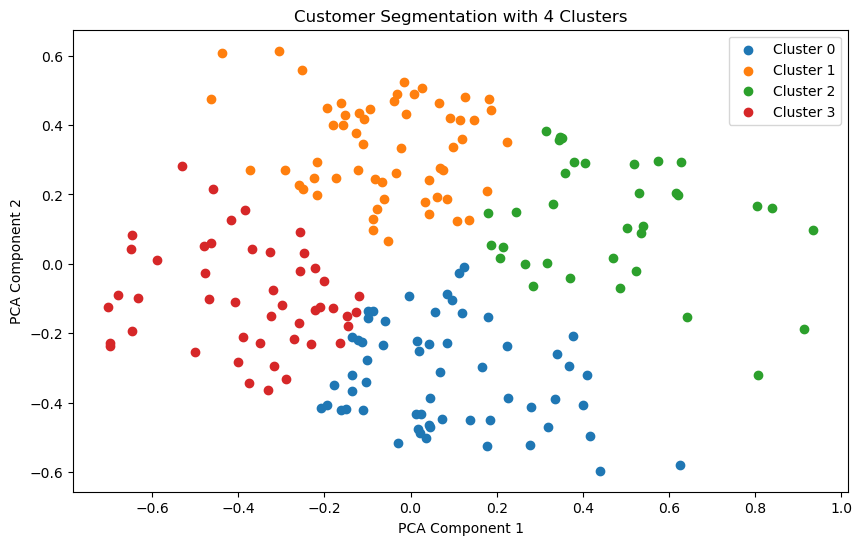

Optimal number of clusters (k): 4
Davies-Bouldin Index: 0.8885295204901547


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge datasets
customer_transactions = transactions_df.merge(customers_df, on="CustomerID")

# Feature Engineering
customer_features = customer_transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "Quantity": "sum",    # Total products purchased
    "TransactionDate": "count"  # Purchase frequency
}).reset_index()

# Add signup age (time since signup)
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
customers_df["SignupAge"] = (pd.Timestamp.now() - customers_df["SignupDate"]).dt.days
customer_features = customer_features.merge(customers_df[["CustomerID", "SignupAge"]], on="CustomerID")

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))

# Perform clustering with K-Means
best_k = 0
best_dbi = float("inf")
best_model = None
dbi_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    dbi = davies_bouldin_score(scaled_features, labels)
    dbi_scores.append(dbi)
    
    if dbi < best_dbi:
        best_k = k
        best_dbi = dbi
        best_model = kmeans

# Add cluster labels to the original data
customer_features["Cluster"] = best_model.labels_

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    cluster_data = reduced_features[customer_features["Cluster"] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

plt.title(f"Customer Segmentation with {best_k} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# Save clustering results
customer_features.to_csv("Customer_Segmentation.csv", index=False)

# Print clustering metrics
print(f"Optimal number of clusters (k): {best_k}")
print(f"Davies-Bouldin Index: {best_dbi}")
